In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

C:\Users\HRISHIKESH\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Loading data

In [3]:
model_df = pd.read_csv('../data/model_df.csv')
model_df.head()

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2020-04-01,74,-4.0,-2.0,4.0,65.0,-1.0,1.0,-9.0,9.0,-33.0,4.0,0.0,-1.0,0.0
1,2020-05-01,72,-2.0,-4.0,-2.0,4.0,65.0,-1.0,1.0,-9.0,9.0,-33.0,4.0,0.0,-1.0
2,2020-01-01,87,15.0,-2.0,-4.0,-2.0,4.0,65.0,-1.0,1.0,-9.0,9.0,-33.0,4.0,0.0
3,2020-02-01,88,1.0,15.0,-2.0,-4.0,-2.0,4.0,65.0,-1.0,1.0,-9.0,9.0,-33.0,4.0
4,2020-03-01,86,-2.0,1.0,15.0,-2.0,-4.0,-2.0,4.0,65.0,-1.0,1.0,-9.0,9.0,-33.0


In [4]:
#train test split

In [5]:
def train_test_split(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-8].values, data[-8:].values
    
    return train, test

train, test = train_test_split(model_df)

In [6]:
print('Train Shape :',train.shape)
print(" ")
print('Test Shape :',test.shape)

Train Shape : (19, 13)
 
Test Shape : (8, 13)


In [7]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [8]:
#Shapes
print(X_train.shape)
print(' ')
print(y_train.shape)
print(' ')
print(X_test.shape)
print(' ')
print(y_test.shape)

(19, 12)
 
(19,)
 
(8, 12)
 
(8,)


In [9]:
# Modeling Functions

In [10]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [11]:

def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_excel(r'../data/BQ-Assignment-Data-Analytics.xlsx') 
    original_df.rename(columns=lambda x: x.replace(' ', '_'),inplace=True)
    original_df.columns= original_df.columns.str.lower()
    original_df.date = original_df.date.apply(lambda x: str(x)[:-4])
    original_df=original_df[['date','sales']]
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [12]:
original_df=load_original_df()
list(original_df[-13:].date)

[Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00')]

In [13]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [14]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-8:], unscaled_df.pred_value[-8:]))
    mae = mean_absolute_error(original_df.sales[-8:], unscaled_df.pred_value[-8:])
    r2 = r2_score(original_df.sales[-8:], unscaled_df.pred_value[-8:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [15]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'../model_output/{model_name}_forecast.png')

In [16]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

RMSE: 235.50690011122816
MAE: 188.0
R2 Score: -453.677084667606


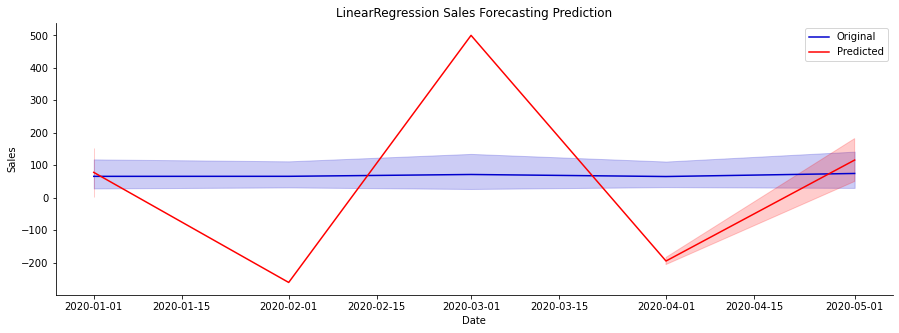

In [17]:
run_model(train, test, LinearRegression(), 'LinearRegression')

In [18]:
# random Forest regressor

RMSE: 25.446021299998947
MAE: 22.0
R2 Score: -4.308056872037914


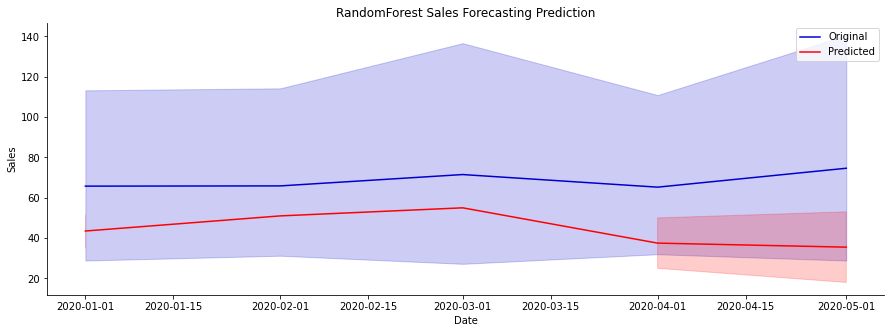

In [19]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 'RandomForest')

In [20]:
#XGBoost

RMSE: 45.64263357870578
MAE: 35.25
R2 Score: -16.078006916869477


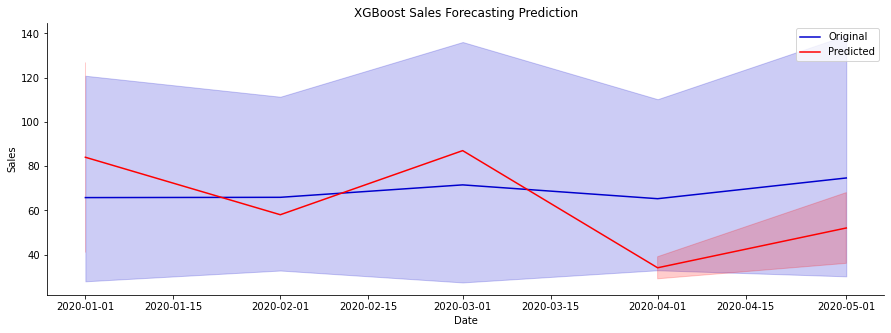

In [21]:
run_model(train, test, XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror'), 'XGBoost')

In [22]:
#LSTM

In [23]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

Using TensorFlow backend.


In [24]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
19/19 [==============================] - 2s 123ms/step - loss: 0.7129
Epoch 2/200
19/19 [==============================] - 0s 2ms/step - loss: 0.3457
Epoch 3/200
19/19 [==============================] - 0s 2ms/step - loss: 0.2242
Epoch 4/200
19/19 [==============================] - 0s 2ms/step - loss: 0.2076
Epoch 5/200
19/19 [==============================] - 0s 2ms/step - loss: 0.2000
Epoch 6/200
19/19 [==============================] - 0s 2ms/step - loss: 0.1952
Epoch 7/200
19/19 [==============================] - 0s 2ms/step - loss: 0.1910
Epoch 8/200
19/19 [==============================] - 0s 2ms/step - loss: 0.1865
Epoch 9/200
19/19 [==============================] - 0s 2ms/step - loss: 0.1821
Epoch 10/200
19/19 [==============================] - 0s 2ms/step - loss: 0.1779
Epoch 11/200
19/19 [==============================] - 0s 2ms/step - loss: 0.1740
Epoch 12/200
19/19 [==============================] - 0s 2ms/step - loss: 0.1703
Epoch 13/200
19/19 [===============

19/19 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 103/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0496
Epoch 104/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0490
Epoch 105/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0484
Epoch 106/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0478
Epoch 107/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0473
Epoch 108/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0467
Epoch 109/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0461
Epoch 110/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0455
Epoch 111/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0450
Epoch 112/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 113/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0439
Epoch 114/200
19/19 [=========

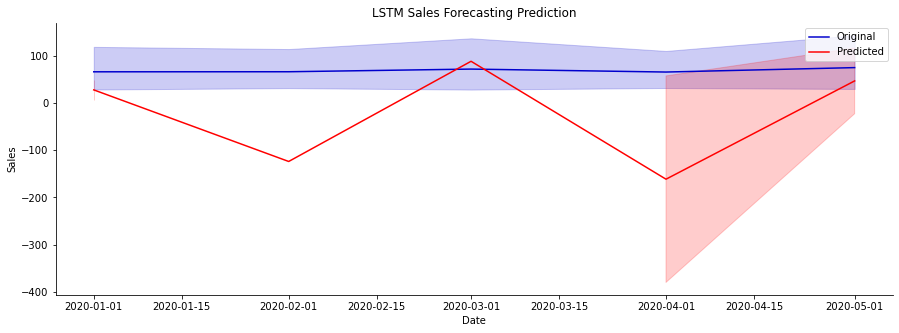

In [25]:
lstm_model(train, test)

In [26]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )